In [1]:
! pip install numpy h5py pandas

In [2]:
import h5py as h5  #for handling data format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
Data_SSE  = h5.File('COMPAS_Output_SSE.h5')

In [4]:
list(Data_SSE.keys())

['Run_Details', 'SSE_Supernovae', 'SSE_System_Parameters']

In [5]:
SP_SSE = Data_SSE['SSE_System_Parameters']
list(SP_SSE.keys())

['Ang_Momentum',
 'CH_on_MS',
 'Evolution_Status',
 'Luminosity',
 'Mass',
 'Mass@ZAMS',
 'Mass_Env',
 'Metallicity@ZAMS',
 'Omega@ZAMS',
 'PO_LBV_Factor',
 'PO_Sigma_Kick_CCSN_BH',
 'PO_Sigma_Kick_CCSN_NS',
 'PO_Sigma_Kick_ECSN',
 'PO_Sigma_Kick_USSN',
 'PO_WR_Factor',
 'Radius@ZAMS',
 'Record_Type',
 'SEED',
 'SN_Kick_Magnitude_Random_Number',
 'Stellar_Type',
 'Stellar_Type@ZAMS',
 'Teff']

In [6]:
print(SP_SSE['Teff'].attrs['units']) # attrs refers to attributes
print(SP_SSE['Luminosity'].attrs['units'])

b'K'
b'Lsol'


In [7]:
L_SSE = SP_SSE['Luminosity'][()]
print(L_SSE.shape)                   # number of systems in this file
print(L_SSE[:5])                    # the values of the first 3 entries
T_SSE = SP_SSE['Teff'][()]
print(T_SSE.shape)                   # number of systems in this file
print(T_SSE[:5])                    # the values of the first 3 entries

(1000,)
[9.83057747 0.51492994 1.16861132 2.50223439 2.90240813]
(1000,)
[8775.36404698 5511.16080309 6182.71514716 6734.61055788 3587.45982813]


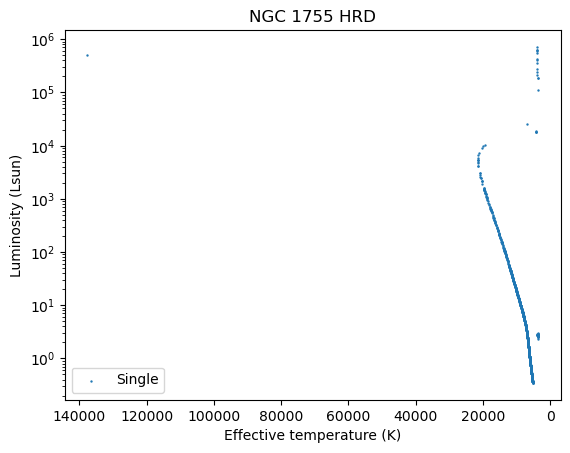

In [8]:
plt.scatter(T_SSE, L_SSE, label = 'Single', s = 0.5)
plt.gca().invert_xaxis()
plt.title('NGC 1755 HRD')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()

In [9]:
def restrict(df, col, lower_limit, upper_limit):
    mask = (df[col] >= lower_limit) & (df[col] <= upper_limit)
    return df[mask]

In [10]:
SSE_file = pd.DataFrame({
           'L': L_SSE,
           'logL': np.log10(L_SSE),
           'Teff': T_SSE,
           'M': SP_SSE['Mass'][()],
           'Z': SP_SSE['Metallicity@ZAMS'][()],
           'type': SP_SSE['Stellar_Type'][()]
})
SSE_file = restrict(SSE_file, 'type', 0, 1) #MS stars only

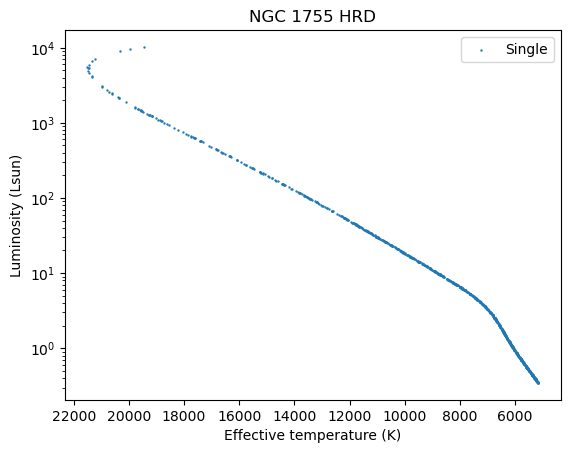

In [11]:
plt.scatter(SSE_file.Teff, SSE_file.L, label = 'Single', s = 0.5)
plt.gca().invert_xaxis()
plt.title('NGC 1755 HRD')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()

In [13]:
SSE_file.to_csv('SSE.txt', sep='\t', index=False)

df_n = []
for n in range(1,8):
    with open(f"output_YBC ({n}).txt") as f:
        lines = f.readlines()
        labels = list(lines[0].split(" "))[:-1]
        for i in range(1,len(lines)):
            if i%2:
                numbers_str = lines[i].split()
                x = np.array([float(num) for num in numbers_str])
                df_n.append(x)
                
df_n = pd.DataFrame(df_n, columns=labels)
df_n = df_n.apply(pd.to_numeric)

In [15]:
df_n = []
with open("output_YBC_test.txt") as f:
    lines = f.readlines()
    labels = list(lines[0].split(" "))[:-1]
    for i in range(1,len(lines)):
        if i%2:
            numbers_str = lines[i].split()
            x = np.array([float(num) for num in numbers_str])
            df_n.append(x)
                
df_n = pd.DataFrame(df_n, columns=labels)
df_n = df_n.apply(pd.to_numeric)

In [16]:
def convert_to_mag(L, BC_F, A_coeff):
    '''
    # ref: https://www.nature.com/articles/s41550-021-01597-5#Sec2
    M_bol = 4.74 - 2.5*np.log10(L)
    M_F = np.array(M_bol) - np.array(BC_F)
    '''
    M_F = np.array(BC_F)
    return M_F +  A_coeff * 0.14 + 18.29 #E(B-V) + (m-M)

In [17]:
simul_mF814W_SSE = convert_to_mag(SSE_file.L, df_n.F814W, 2.04)
simul_mF336W_SSE = convert_to_mag(SSE_file.L, df_n.F336W, 5.16)

In [18]:
np.max(simul_mF814W_SSE)

23.909709999999997

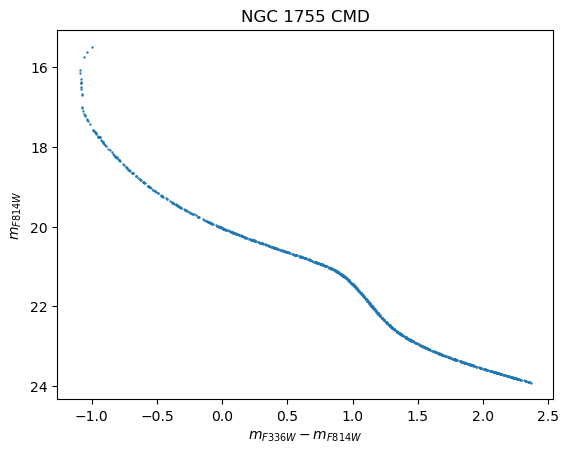

In [19]:
plt.scatter(simul_mF336W_SSE - simul_mF814W_SSE, simul_mF814W_SSE, s = 0.5)
plt.title('NGC 1755 CMD')
plt.xlabel(r'$m_{F336W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.gca().invert_yaxis()
plt.ticklabel_format(useOffset=False)

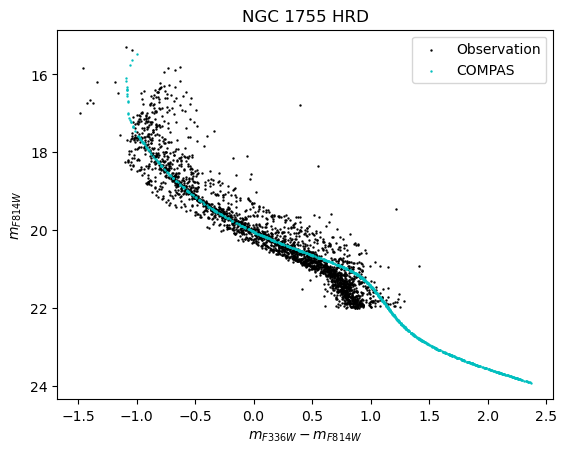

In [20]:
obs = pd.read_csv('n1755_decont.csv')
plt.scatter(obs.F336W-obs.F814W, obs.F814W, s = 0.5, c='k', label = 'Observation')
plt.scatter(simul_mF336W_SSE - simul_mF814W_SSE, simul_mF814W_SSE, s = 0.5, c='c', label = 'COMPAS')
plt.xlabel(r'$m_{F336W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.gca().invert_yaxis()
plt.title('NGC 1755 HRD')
plt.legend()